# COVID-19 Global Forecasting

This notebook will focus on forecasting the number of new cases and deaths caused by the COVID-19 virus during the month of April 2020.

The link to the competition description and data sources is the following:
https://www.kaggle.com/c/covid19-global-forecasting-week-3/data

## Data

In this notebook we'll use the Kaggle dataset with confirmed cases and fatalities by country, along with the world population dataset from the United Nations website: https://population.un.org/wpp/Download/Standard/CSV/

In [155]:
# Importing necessary packages
import pandas as pd
import numpy as np
import matplotlib.style as style
import matplotlib.pyplot as plt
import seaborn as sns
import string
import matplotlib.ticker as ticker
import re
from collections import Counter
style.use('fivethirtyeight')
palette = "ch:-.2,2.5,dark=.3_r"

# Packages for modelling 
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Interactive shell settings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Reading Kaggle data
train = pd.read_csv('/Users/miketondu/Dropbox/Data Science/KAGGLE/COVID-19/covid19-global-forecasting-week-4/train.csv', 
                   date_parser='Date' )
test = pd.read_csv('/Users/miketondu/Dropbox/Data Science/KAGGLE/COVID-19/covid19-global-forecasting-week-4/test.csv',
                   date_parser='Date')
submission = pd.read_csv('/Users/miketondu/Dropbox/Data Science/KAGGLE/COVID-19/covid19-global-forecasting-week-4/submission.csv')

# Reading united nations population data
pop = pd.read_csv('/Users/miketondu/Dropbox/Data Science/KAGGLE/COVID-19/WPP2019_TotalPopulationBySex.csv')


In [156]:
# First look at the datasets
train.head()
test.head()
submission.head()
pop.head()

Id Province_State Country_Region        Date  ConfirmedCases  Fatalities
0   1            NaN    Afghanistan  2020-01-22             0.0         0.0
1   2            NaN    Afghanistan  2020-01-23             0.0         0.0
2   3            NaN    Afghanistan  2020-01-24             0.0         0.0
3   4            NaN    Afghanistan  2020-01-25             0.0         0.0
4   5            NaN    Afghanistan  2020-01-26             0.0         0.0

ForecastId Province_State Country_Region        Date
0           1            NaN    Afghanistan  2020-04-02
1           2            NaN    Afghanistan  2020-04-03
2           3            NaN    Afghanistan  2020-04-04
3           4            NaN    Afghanistan  2020-04-05
4           5            NaN    Afghanistan  2020-04-06

ForecastId  ConfirmedCases  Fatalities
0           1               1           1
1           2               1           1
2           3               1           1
3           4               1           1
4           5               1           1

LocID     Location  VarID Variant  Time  MidPeriod   PopMale  PopFemale  \
0      4  Afghanistan      2  Medium  1950     1950.5  4099.243   3652.874   
1      4  Afghanistan      2  Medium  1951     1951.5  4134.756   3705.395   
2      4  Afghanistan      2  Medium  1952     1952.5  4174.450   3761.546   
3      4  Afghanistan      2  Medium  1953     1953.5  4218.336   3821.348   
4      4  Afghanistan      2  Medium  1954     1954.5  4266.484   3884.832   

   PopTotal  PopDensity  
0  7752.117      11.874  
1  7840.151      12.009  
2  7935.996      12.156  
3  8039.684      12.315  
4  8151.316      12.486

In [157]:
# Getting 2020 population estimates from the UN, with the medium variant
pop_20 = pop[(pop['Time']==2020) & (pop['Variant']=='Medium')]
pop_20 = pop_20.groupby('Location')[['PopMale','PopFemale','PopTotal','PopDensity']].sum()

# Merging population with train dataset
train = pd.merge(train, pop_20, left_on='Country_Region', right_on=pop_20.index )
test = pd.merge(test, pop_20, left_on='Country_Region', right_on=pop_20.index )

train.head(10000)

Id                Province_State            Country_Region  \
0         1                           NaN               Afghanistan   
1         2                           NaN               Afghanistan   
2         3                           NaN               Afghanistan   
3         4                           NaN               Afghanistan   
4         5                           NaN               Afghanistan   
5         6                           NaN               Afghanistan   
6         7                           NaN               Afghanistan   
7         8                           NaN               Afghanistan   
8         9                           NaN               Afghanistan   
9        10                           NaN               Afghanistan   
10       11                           NaN               Afghanistan   
11       12                           NaN               Afghanistan   
12       13                           NaN               Afghanistan   
13       14                           NaN               Afghanistan   
14       15                           NaN               Afghanistan   
15       16                           NaN               Afghanistan   
16       17                           NaN               Afghanistan   
17       18                           NaN               Afghanistan   
18       19                           NaN               Afghanistan   
19       20                           NaN               Afghanistan   
20       21                           NaN               Afghanistan   
21       22                           NaN               Afghanistan   
22       23                           NaN               Afghanistan   
23       24                           NaN               Afghanistan   
24       25                           NaN               Afghanistan   
25       26                           NaN               Afghanistan   
26       27                           NaN               Afghanistan   
27       28                           NaN               Afghanistan   
28       29                           NaN               Afghanistan   
29       30                           NaN               Afghanistan   
30       31                           NaN               Afghanistan   
31       32                           NaN               Afghanistan   
32       33                           NaN               Afghanistan   
33       34                           NaN               Afghanistan   
34       35                           NaN               Afghanistan   
35       36                           NaN               Afghanistan   
36       37                           NaN               Afghanistan   
37       38                           NaN               Afghanistan   
38       39                           NaN               Afghanistan   
39       40                           NaN               Afghanistan   
40       41                           NaN               Afghanistan   
41       42                           NaN               Afghanistan   
42       43                           NaN               Afghanistan   
43       44                           NaN               Afghanistan   
44       45                           NaN               Afghanistan   
45       46                           NaN               Afghanistan   
46       47                           NaN               Afghanistan   
47       48                           NaN               Afghanistan   
48       49                           NaN               Afghanistan   
49       50                           NaN               Afghanistan   
50       51                           NaN               Afghanistan   
51       52                           NaN               Afghanistan   
52       53                           NaN               Afghanistan   
53       54                           NaN               Afghanistan   
54       55                           NaN               Afghanistan   
55       56                      

## Exploratory Data Analysis
Basic aggregated facts about dataset

In [159]:
# Train data description
train[['ConfirmedCases', 'Fatalities']].describe()
train.info()
print('\n')

# Main facts
max_date = train.Date.max()
total_countries = train.Country_Region.nunique()
total_cases = train[train['Date']==max_date].ConfirmedCases.sum()
total_deaths =train[train['Date']==max_date].Fatalities.sum()

print('Max Date:', max_date)
print('Number of countries:', total_countries) 
print('Total Cases:', total_cases)
print('Total Deaths:', total_deaths)

ConfirmedCases    Fatalities
count    19359.000000  19359.000000
mean       959.639806     54.134304
std       7615.803396    655.716654
min          0.000000      0.000000
25%          0.000000      0.000000
50%          1.000000      0.000000
75%         91.000000      1.000000
max     163027.000000  19468.000000

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19359 entries, 0 to 19358
Data columns (total 10 columns):
Id                19359 non-null int64
Province_State    6399 non-null object
Country_Region    19359 non-null object
Date              19359 non-null object
ConfirmedCases    19359 non-null float64
Fatalities        19359 non-null float64
PopMale           19359 non-null float64
PopFemale         19359 non-null float64
PopTotal          19359 non-null float64
PopDensity        19359 non-null float64
dtypes: float64(6), int64(1), object(3)
memory usage: 1.6+ MB


Max Date: 2020-04-11
Number of countries: 163
Total Cases: 1146021.0
Total Deaths: 83240.0


In [160]:
# Create a fatalities per million column
train['fatalities_per_million'] = round(train['Fatalities']/(train['PopTotal'])*1000,2)

# Countries with the most cases and fatalities ordered by date and cases 
top = (train[train['Date'] == max_date]
       .groupby(['Date','Country_Region'])[['ConfirmedCases','Fatalities','fatalities_per_million','PopTotal']]
       .sum()
       .sort_values(by=['ConfirmedCases','Fatalities'], ascending=False))

top.head(25)
top.tail(25)

ConfirmedCases  Fatalities  fatalities_per_million  \
Date       Country_Region                                                       
2020-04-11 Spain                 163027.0     16606.0                  355.17   
           Italy                 152271.0     19468.0                  321.99   
           France                130727.0     13851.0                  212.20   
           Germany               124908.0      2736.0                   32.66   
           China                  83014.0      3343.0                    2.29   
           United Kingdom         79874.0      9892.0                  145.70   
           Turkey                 52167.0      1101.0                   13.05   
           Belgium                28018.0      3346.0                  288.71   
           Switzerland            25107.0      1036.0                  119.70   
           Netherlands            24571.0      2653.0                  154.84   
           Canada                 23303.0       653.0                   17.31   
           Brazil                 20727.0      1124.0                    5.29   
           Portugal               15987.0       470.0                   46.09   
           Austria                13806.0       337.0                   37.42   
           Israel                 10743.0       101.0                   11.67   
           Sweden                 10151.0       887.0                   87.83   
           Ireland                 8928.0       320.0                   64.81   
           India                   8446.0       288.0                    0.21   
           Ecuador                 7257.0       315.0                   17.85   
           Chile                   6927.0        73.0                    3.82   
           Peru                    6848.0       181.0                    5.49   
           Norway                  6409.0       119.0                   21.95   
           Poland                  6356.0       208.0                    5.50   
           Australia               6303.0        57.0                    2.25   
           Denmark                 6191.0       260.0                   44.89   

                               PopTotal  
Date       Country_Region                
2020-04-11 Spain           4.675478e+04  
           Italy           6.046183e+04  
           France          7.180086e+05  
           Germany         8.378395e+04  
           China           4.749768e+07  
           United Kingdom  7.467460e+05  
           Turkey          8.433907e+04  
           Belgium         1.158962e+04  
           Switzerland     8.654618e+03  
           Netherlands     8.567436e+04  
           Canada          4.529059e+05  
           Brazil          2.125594e+05  
           Portugal        1.019671e+04  
           Austria         9.006400e+03  
           Israel          8.655541e+03  
           Sweden          1.009927e+04  
           Ireland         4.937796e+03  
           India           1.380004e+06  
           Ecuador         1.764306e+04  
           Chile           1.911621e+04  
           Peru            3.297185e+04  
           Norway          5.421242e+03  
           Poland          3.784661e+04  
           Australia       2.039990e+05  
           Denmark         1.737661e+04

ConfirmedCases  Fatalities  \
Date       Country_Region                                                 
2020-04-11 Grenada                                     14.0         0.0   
           Belize                                      13.0         2.0   
           Botswana                                    13.0         1.0   
           Malawi                                      12.0         2.0   
           Eswatini                                    12.0         0.0   
           Saint Kitts and Nevis                       12.0         0.0   
           Saint Vincent and the Grenadines            12.0         0.0   
           Chad                                        11.0         0.0   
           Seychelles                                  11.0         0.0   
           Suriname                                    10.0         1.0   
           Gambia                                       9.0         1.0   
           Nepal                                        9.0         0.0   
           Cabo Verde                                   8.0         1.0   
           Nicaragua                                    8.0         1.0   
           Central African Republic                     8.0         0.0   
           Holy See                                     8.0         0.0   
           Sierra Leone                                 8.0         0.0   
           Mauritania                                   7.0         1.0   
           Bhutan                                       5.0         0.0   
           Burundi                                      5.0         0.0   
           Sao Tome and Principe                        4.0         0.0   
           South Sudan                                  4.0         0.0   
           Western Sahara                               4.0         0.0   
           Papua New Guinea                             2.0         0.0   
           Timor-Leste                                  2.0         0.0   

                                             fatalities_per_million   PopTotal  
Date       Country_Region                                                       
2020-04-11 Grenada                                             0.00    112.519  
           Belize                                              5.03    397.621  
           Botswana                                            0.43   2351.625  
           Malawi                                              0.10  19129.955  
           Eswatini                                            0.00   1160.164  
           Saint Kitts and Nevis                               0.00     53.192  
           Saint Vincent and the Grenadines                    0.00    110.947  
           Chad                                                0.00  16425.859  
           Seychelles                                          0.00     98.340  
           Suriname                                            1.70    586.634  
           Gambia                                              0.41   2416.664  
           Nepal                                               0.00  29136.808  
           Cabo Verde                                          1.80    555.988  
           Nicaragua                                           0.15   6624.554  
           Central African Republic                            0.00   4829.764  
           Holy See                                            0.00      0.809  
           Sierra Leone                                        0.00   7976.985  
           Mauritania                                          0.22   4649.660  
           Bhutan                                              0.00    771.612  
           Burundi                                             0.00  11890.781  
           Sao Tome and Principe                               0.00    219.161  
           South Sudan                                         0.00  11193.729  
           Western Sahara                                      0.00    597.

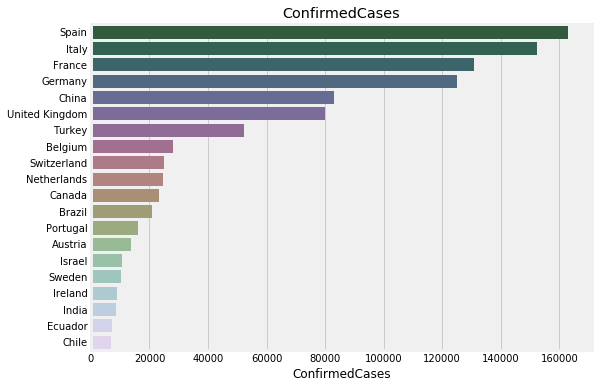

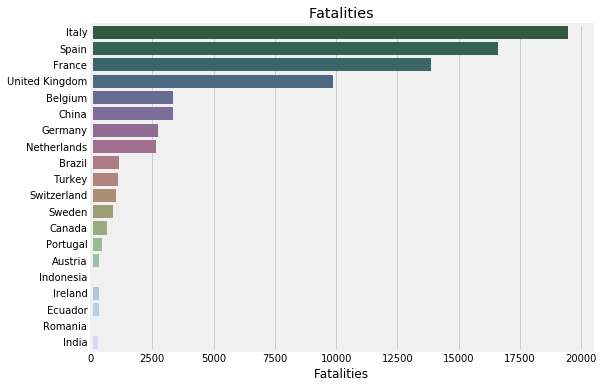

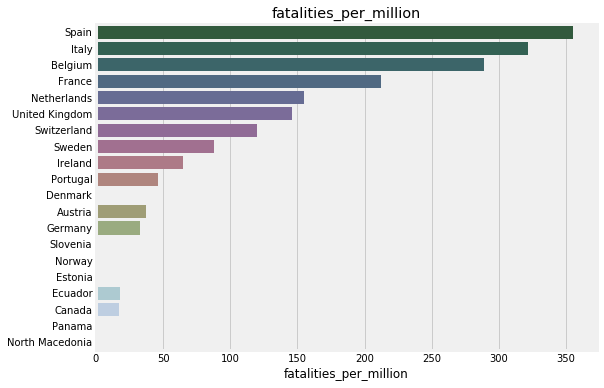

In [161]:
# Bar graph for most affected countries by cases and fatalities
def bar_graph(df, dep_var, size=15):
    fig,axes = plt.subplots(figsize=(8,6))
    sns.barplot(y =df.index.get_level_values(1)[0:size],
                x=df[dep_var][0:size], 
                palette=palette,
                order= df.sort_values(by=dep_var,ascending=False).index.get_level_values(1)[0:size])
    plt.title(dep_var)
    plt.ylabel('')
    plt.show();

bar_graph(top,'ConfirmedCases', 20)
bar_graph(top,'Fatalities', 20)
bar_graph(top[top['PopTotal']>=1000],'fatalities_per_million', 20) # exclude countries with less than one million total population



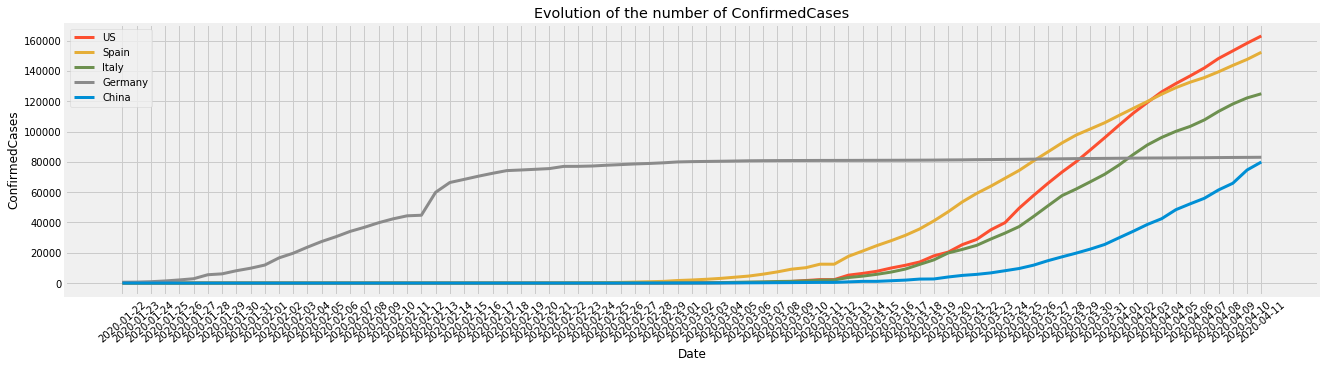

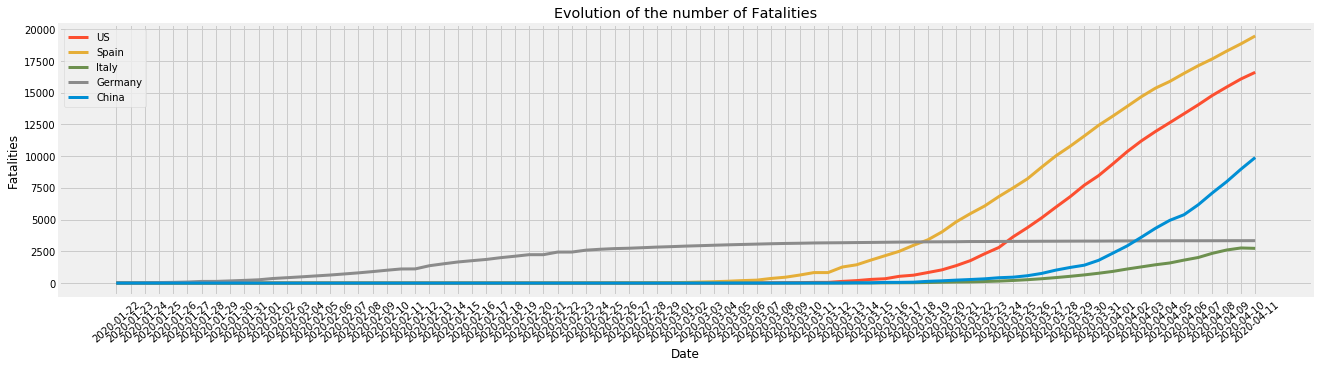

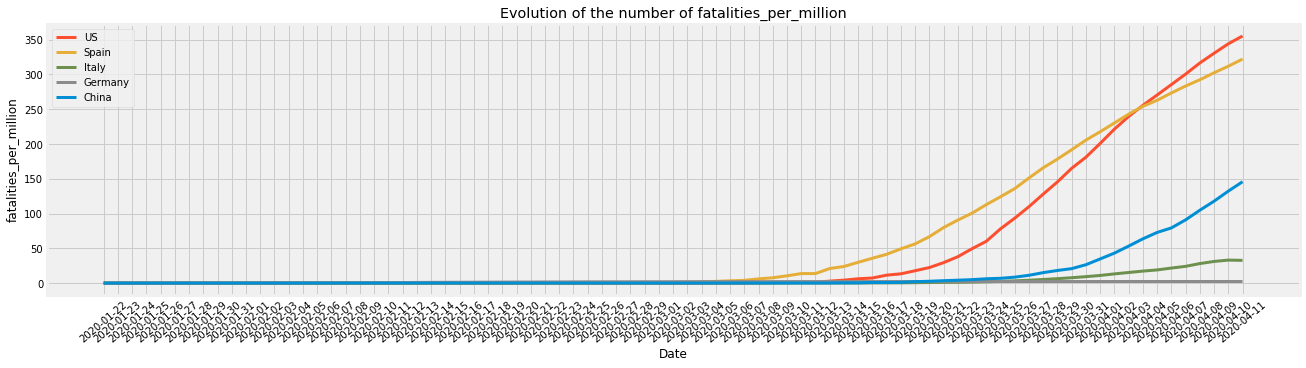

In [163]:
# Creating graphs with case count, fatality, and fatalities per million citizens trends by country
def Country_graph(df, dep_var,*argv):
    fig, axes=plt.subplots(figsize=(20,5))
    labels=argv
    for a in argv: 
        country=df.loc[(df['Country_Region']==a)]
        sns.lineplot(country['Date'],country[dep_var],linewidth=3,palette=palette)
        plt.xticks(rotation=40)
        plt.legend(labels)
        axes.set(title='Evolution of the number of ' + dep_var )

                
train_sum=train.groupby(['Date','Country_Region']).agg('sum').reset_index()
# Recorded cases
Country_graph(train_sum,'ConfirmedCases','US','Spain','Italy','Germany', 'China','Iran', 'United Kingdom')
# Fatalities
Country_graph(train_sum,'Fatalities','US','Spain','Italy','Germany', 'China','Iran', 'United Kingdom')  
# Fatalities per million citizens
Country_graph(train_sum,'fatalities_per_million','US','Spain','Italy','Germany', 'China','Iran', 'United Kingdom')       

## Training and Prediction
This section will use different algorithms to create a prediction model of the evolution of cases of COVID-19. Two separate models will be initialized and run in order to predict both target variables: 'ConfirmedCases' and 'Fatalities'.


In [166]:
test.head()

ForecastId Province_State Country_Region        Date    PopMale  PopFemale  \
0           1            NaN    Afghanistan  2020-04-02  19976.265  18952.076   
1           2            NaN    Afghanistan  2020-04-03  19976.265  18952.076   
2           3            NaN    Afghanistan  2020-04-04  19976.265  18952.076   
3           4            NaN    Afghanistan  2020-04-05  19976.265  18952.076   
4           5            NaN    Afghanistan  2020-04-06  19976.265  18952.076   

    PopTotal  PopDensity  
0  38928.341      59.627  
1  38928.341      59.627  
2  38928.341      59.627  
3  38928.341      59.627  
4  38928.341      59.627

In [168]:
# Preprocessing
model = train.copy()
model.fillna('Nan',inplace= True)#.drop('id',axis=1,inplace=True)
model = pd.get_dummies(model)

# split data into X and y
X= model.loc[:,model.columns!='ConfirmedCases']
y = model.loc[:,'ConfirmedCases']


In [ ]:
# split data into train and test sets
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))